In [1]:
'''
Sample script for evaluation

Given an accession number curr_accnum and relevant prior information available in './csv/imaging_evaluation_with_priors_demo.csv'
initial risk assessment and refinement is performed
Inputs - 
1. curr accession number in curr_accnum
2. csv file containing information about prior context in imaging_csv
3. data directory containing all MRI data pre-processed as h5 or nii or mha files available in data_directory './demo_data/'
4. number of prior MRI exams to use in num_timepoints_to_use

'''

"\nSample script for evaluation\n\nGiven an accession number curr_accnum and relevant prior information available in './csv/imaging_evaluation_with_priors_demo.csv'\ninitial risk assessment and refinement is performed\nInputs - \n1. curr accession number in curr_accnum\n2. csv file containing information about prior context in imaging_csv\n3. data directory containing all MRI data pre-processed as h5 or nii or mha files available in data_directory './demo_data/'\n4. number of prior MRI exams to use in num_timepoints_to_use\n\n"

In [2]:
import pandas as pd
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

curr_wd = os.getcwd()
sys.path.append(curr_wd) 

import tensorflow as tf

from data.data_processing import get_imaging_priors_demo

from config import risk_assm_config as RL_cfg
from config import temporal_learner_config as TL_cfg
from utils.ModelDefinitions import Context_aware_imaging_only_model

d:\Software\anaconda3\envs\test_env\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [4]:

data_directory = './demo_data/'
imaging_csv = './csv/imaging_evaluation_with_priors_demo.csv'
# checkpoint_wts = './pretrained_wts/imaging_chkpt'
checkpoint_wts = ''
# Note that checkpoint points are not available here.

In [5]:
''' Instantiation Imaging Only Model '''
ca_imaging_model = Context_aware_imaging_only_model(RL_cfg, TL_cfg)

''' Loading weights from checkpoint'''
if checkpoint_wts:
    ca_imaging_model.load_weights(checkpoint_wts)

Instantiating axt2 encoder
Instantiating diff encoder
Instantiated Representation Learner
Initializing temporal representation learner


In [6]:
''' Get current and prior information stored in the demo csv file'''
# Load csv files with prior information
df = pd.read_csv(imaging_csv,
                    converters={'Curr_AccNum': pd.eval, 'Curr_Age': pd.eval, 
                                'Previous_AccNum': pd.eval, 'Previous_Age':pd.eval, 
                                'Curr_MaxPIRADS': pd.eval})
df

,PatientID,Curr_Age,Curr_AccNum,Curr_MaxPIRADS,Previous_AccNum,Previous_Age
0,10003,72,1000003,2,[1000002],[70]
1,10044,71,1000044,4,[1000043],[70]


In [7]:
''' Load current and prior MRI exams for a given patient and accession (study)
i_recent - list containing recent MRI [T2WI, DWI]
i_prior - list containing prior MRIs [T2WI, DWI]
ti_recent - time of recent MRI (set to 1)
ti_prior - time of prior MRIs (difference in years between current and prior MRIs)
'''
current_accnum = 1000044

# get prior and current MRI exams along with time intervals between exams
i_prior, ti_prior, i_recent, ti_recent =  get_imaging_priors_demo(current_accnum, df, data_directory, num_timepoints_to_use = 3)

Loading current imaging data from 1000044
Loading prior imaging data from 1000043


Text(0.5, 1.0, 'high b-value image')

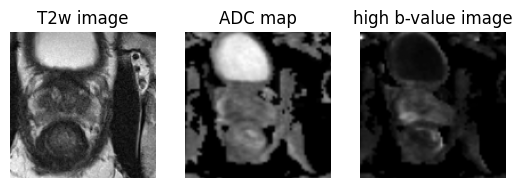

In [8]:
''' Visualize exams'''
t2wi_recent = i_recent[0].squeeze()
dwi_recent = i_recent[1].squeeze()

slice_to_display = 12

plt.figure()
plt.subplot(1,3,1)
plt.imshow(t2wi_recent[...,slice_to_display], cmap='gray')
plt.axis('off')
plt.title('T2w image')
plt.subplot(1,3,2)
plt.imshow(dwi_recent[...,slice_to_display,0], cmap='gray')
plt.axis('off')
plt.title('ADC map')
plt.subplot(1,3,3)
plt.imshow(dwi_recent[...,slice_to_display,1], cmap='gray')
plt.axis('off')
plt.title('high b-value image')

In [9]:
''' Get initial and refined risk'''
initial_risk, refined_risk = ca_imaging_model.evaluate_risk([i_prior, ti_prior, i_recent, ti_recent])

In [10]:
print(f'Probability of PCa with current exam {initial_risk[0]}')
print(f'Probability of PCa with current+priors {refined_risk[0]}')

Probability of PCa with current exam 0.541832685470581
Probability of PCa with current+priors 0.7304400205612183
